In [1]:
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8
rcParams.update({'font.size':16})


import numpy as np
from ipywidgets import widgets
import matplotlib.pyplot as plt

from mpmath import mp
mp.dps = 50

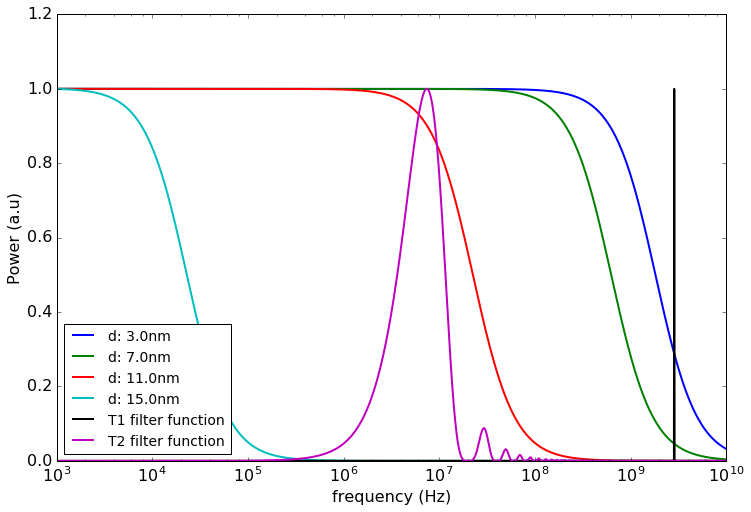

In [2]:
# K_b*T at RT is 4.04*10**-21 J

def spec(f,k,V,t,T):
    t_n = t*np.exp(k*V/(4.04*10**-21*(T/298.)))
    return (2 * t_n)/(np.pi* (1+np.square(t_n*f)))

def F1(f,b,T2):
    w_p = 2.865E9 + 28E6*b
    w_n = 2.865E9 - 28E6*b
    k = 1/T2
    return (1/np.pi)*( k/(k**2 + np.square(f-w_p)) + k/(k**2 + np.square(f-w_n)))

def F2(f,tau):
    return (1/(4*np.pi**2)) * (2/tau) * np.sin(2*np.pi*tau*f/4.)**4 / (f/4.)**2
    
f = np.logspace(3,10,2000)
t = 10**-9.3
k = 26E3

for r in (1.5,3.5,5.5,7.5):
    V = (4/3.0)*np.pi*(r*10**-9)**3
    T2 = 500E-9
    plt.semilogx(f,spec(f,k,V,t,298)/np.max(spec(f,k,V,t,298)),linewidth=2,label = "d: %snm"%(2*r))

plt.semilogx(f,F1(f,0,1E-6)/np.max(F1(f,0,1E-6)),'k',linewidth=2,label = "T1 filter function")
plt.semilogx(f,F2(f,1E-7)/np.max(F2(f,1E-7)),linewidth=2,label = "T2 filter function")
plt.legend(loc=3,fontsize=14)
plt.xlabel('frequency (Hz)')
plt.ylabel('Power (a.u)')
plt.ylim([0,1.2])
plt.show()


In [3]:
def spec(f,k,V,t):
    t_n = t*mp.exp(k*V/(mp.mpf(4.04*10**-21)))
    return mp.mpf((2 * t_n)/(mp.pi*(1+mp.power(2,t_n*f))))

def F1(f,b,T2):
    w_p = mp.mpf(2.865E9 + 28E6*b)
    w_n = mp.mpf(2.865E9 - 28E6*b)
    k = mp.mpf(1/T2)
    return mp.mpf((1/mp.pi)*( k/(k**2 + mp.power(f-w_p,2)) + k/(k**2 + mp.power(f-w_n,2))))

def F2(f,tau):
    return (1/(4*mp.pi**2)) * (2/tau) * mp.sin(2*mp.pi*tau*f/4.)**4 / (f/4.)**2

def T1_pred(b,r,b_v):
    k =  mp.mpf(26E3)
    t =  mp.mpf(10**-9.2)
    T1 = mp.mpf(20*1E-6)
    T2 = mp.mpf(1000*1E-9)
    V =  mp.mpf(4/3.0*np.pi*(r*1E-9)**3)
    w_p = mp.mpf(2.865E9 + 28E6*b)
    w_n = mp.mpf(2.865E9 - 28E6*b)
    i = lambda f: F1(f,b,T2)*spec(f,k,V,t)
    S = mp.quad(i,[1E8,w_n-1E8,w_n+1E8,w_p-1E8,w_p+1E8,1E10])
    G_ext = mp.mpf(28E6**2*b_v**2*S)
    return mp.mpf(1/(1/T1+G_ext))

def T2_pred(tau,r,b_v):
    k =  mp.mpf(26E3)
    t =  mp.mpf(10**-9.2)
    T1 = mp.mpf(20*1E-6)
    T2 = mp.mpf(1000*1E-9)
    V =  mp.mpf(4/3.0*np.pi*(r*1E-9)**3)
    i = lambda f: F2(f,tau*2)*spec(f,k,V,t)
    S = mp.quad(i,[1E4,1/tau-1E6,1/tau+1E6,1E8])
    G_ext = mp.mpf(28E6**2*b_v**2*S)
    return mp.mpf(1/(1/T2+G_ext))


b_v = 2.8
R = np.arange(1,15,0.1)
T1 = list( T1_pred(0,r,b_v*(r/3.5))/20E-6 for r in np.nditer(R))
T2 = list( T2_pred(1E-7,r,b_v*(r/3.5))/1E-6 for r in np.nditer(R))

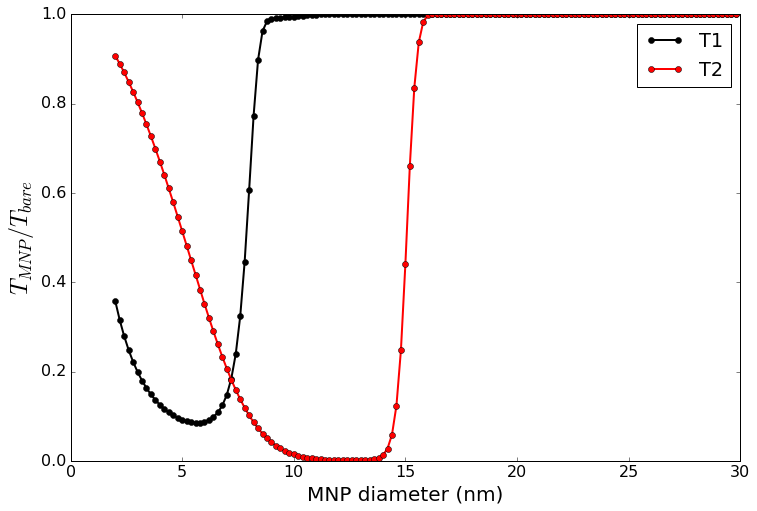

In [4]:
plt.plot(R*2,T1,'k-o',linewidth=2,label='T1')
plt.plot(R*2,T2,'r-o',linewidth=2,label='T2')
plt.xlabel("MNP diameter (nm)",fontsize=20)
plt.ylabel("$T_{MNP} / T_{bare} $",fontsize=24)
plt.legend()
plt.show()


In [5]:
def f(T1,t):
    return mp.mpf(2*T1/t**2*(t-T1+T1*mp.exp(-t/T1)))

def SE(tau,T1,B):
    return mp.exp( -((28E6)**2 * B**2 * tau**2 * f(T1,tau)/2.) )

def SE_pred(k,t,b_var,tau,r):
    V =  mp.mpf(4/3.0*np.pi*(r*1E-9)**3)
    t_n = mp.mpf(t*mp.exp(k*V/(4.04E-21)))
    #T2 = T2_pred(tau,r,b_var)
    return SE(tau,t_n,b_var)

b_v = 2.8
R = np.arange(1,10,0.1)
T2 = list( mp.exp(-2E-7/T2_pred(2E-7,r,b_v*(r/3.5))) for r in np.nditer(R))
S = list( SE_pred(26E3,10**-9.2,b_v*(r/3.5),1E-7,r) for r in np.nditer(R))
C = list(t-t*s for t,s in zip(T2,S))

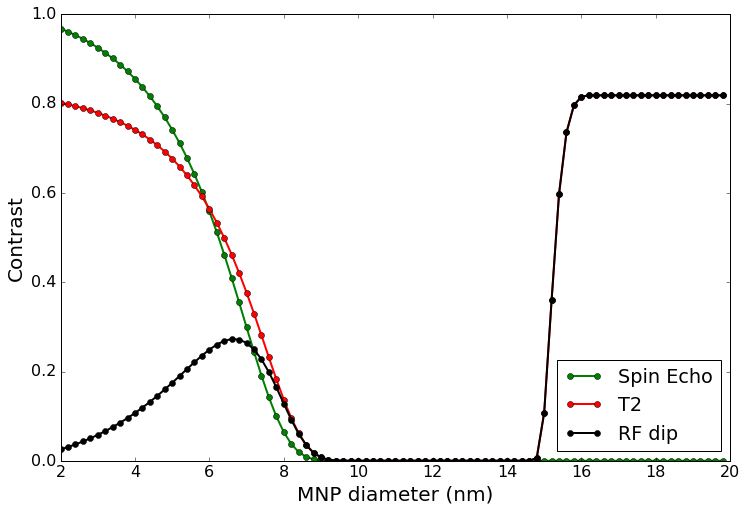

In [6]:
C = list(t-t*s for t,s in zip(T2,S))
plt.plot(2*R,S,'g-o',label="Spin Echo",linewidth=2)
plt.plot(2*R,T2,'r-o',label="T2",linewidth=2)
plt.plot(2*R,C,'k-o',label="RF dip",linewidth=2)
plt.xlabel("MNP diameter (nm)",fontsize=20)
plt.ylabel("Contrast",fontsize=20)
plt.legend(loc=4)
plt.show()

In [153]:
k =  mp.mpf(26E3)
t =  mp.mpf(10**-10)
T1 = mp.mpf(100*1E-6)
T2 = mp.mpf(2000*1E-9)

def spec(f,k,V,t):
    t_n = t*mp.exp(k*V/(mp.mpf(4.04*10**-21)))
    return mp.mpf((2 * t_n)/(mp.pi*(1+mp.power(2,t_n*f))))

def F1(f,b,T2):
    w_p = mp.mpf(2.865E9 + 28E6*b)
    w_n = mp.mpf(2.865E9 - 28E6*b)
    k = mp.mpf(1/T2)
    return mp.mpf((1/mp.pi)*( k/(k**2 + mp.power(f-w_p,2)) + k/(k**2 + mp.power(f-w_n,2))))

def F2(f,tau):
    return (1/(4*mp.pi**2)) * (2/tau) * mp.sin(2*mp.pi*tau*f/4.)**4 / (f/4.)**2

def T1_pred(b,r,b_v):
   
    V =  mp.mpf(4/3.0*np.pi*(r*1E-9)**3)
    w_p = mp.mpf(2.865E9 + 28E6*b)
    w_n = mp.mpf(2.865E9 - 28E6*b)
    i = lambda f: F1(f,b,T2)*spec(f,k,V,t)
    S = mp.quad(i,[1E8,w_n-1E8,w_n+1E8,w_p-1E8,w_p+1E8,1E10])
    G_ext = mp.mpf(28E6**2*b_v**2*S)
    return mp.mpf(1/(1/T1+G_ext))

def T2_pred(tau,r,b_v):
    V =  mp.mpf(4/3.0*np.pi*(r*1E-9)**3)
    i = lambda f: F2(f,tau*2)*spec(f,k,V,t)
    S = mp.quad(i,[1E4,1/tau-1E6,1/tau+1E6,1E8])
    G_ext = mp.mpf(28E6**2*b_v**2*S)
    return mp.mpf(1/(1/T2+G_ext))



In [ ]:

b_v = 2.8
R = np.arange(1,15,0.1)
T1_2_8 = list( T1_pred(0,r,b_v*(r/3.5)) for r in np.nditer(R))
T2_2_8 = list( T2_pred(1E-7,r,b_v*(r/3.5)) for r in np.nditer(R))

In [169]:
b_v = 3


k =  mp.mpf(26E3)
t =  mp.mpf(10**-9.5)
T1 = mp.mpf(100*1E-6)
T2 = mp.mpf(2000*1E-9)
T1_0 = list( T1_pred(0,r,b_v) for r in np.nditer(R))
T2_0 = list( T2_pred(5E-7,r,b_v) for r in np.nditer(R))



k =  mp.mpf(26E3)
t =  mp.mpf(10**-10)
T1_1 = list( T1_pred(0,r,b_v) for r in np.nditer(R))
T2_1 = list( T2_pred(5E-7,r,b_v) for r in np.nditer(R))

k =  mp.mpf(26E3)
t =  mp.mpf(10**-10.5)
T1_2 = list( T1_pred(0,r,b_v) for r in np.nditer(R))
T2_2 = list( T2_pred(5E-7,r,b_v) for r in np.nditer(R))

In [173]:
k =  mp.mpf(26E3)
t =  mp.mpf(10**-11)
T1_3 = list( T1_pred(0,r,b_v) for r in np.nditer(R))
T2_3 = list( T2_pred(5E-7,r,b_v) for r in np.nditer(R))

In [146]:
b_v = 3
T1 = mp.mpf(30*1E-6)
T2 = mp.mpf(800*1E-9)
T1_low = list( T1_pred(0,r,b_v) for r in np.nditer(R))
T2_low = list( T2_pred(5E-7,r,b_v) for r in np.nditer(R))


In [126]:
MNP2_T1 = np.array([1460,386,4012,195,525,2770,1258,1075,324,483,1795,15735,537,339,1319,2247,4462,2217,751,678])*1E-9
MNP11_T1 = np.array([21261,8448,35817])*1E-9
MNP5_T1 = np.array([6199,959,5998,5619])*1E-9
bare_T1 = np.array([292853,319588,100662,31148,54657,46828,99135,229618])*1E-9

In [104]:
def gaussian(X,mu,sigma):
    return np.exp( -(X-mu)**2/(2*sigma**2) )

(2e-08, 0.001)

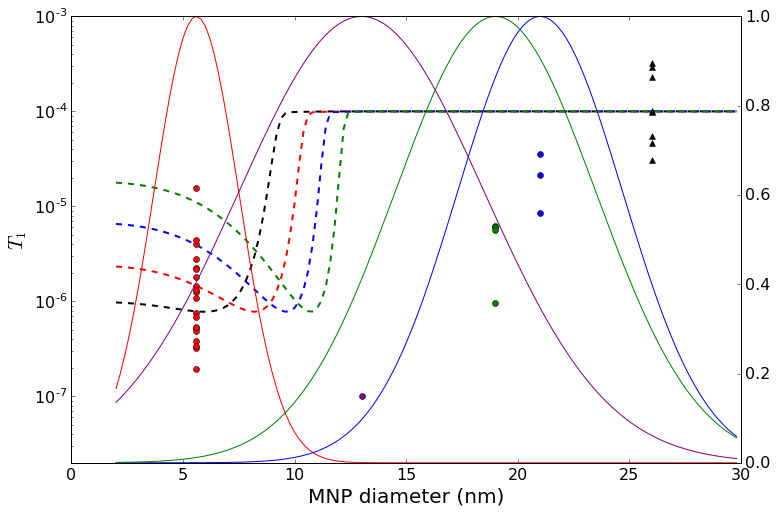

In [174]:
#plt.plot(R*2,T1_high,'k-',linewidth=2,label='T1')
f, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(R*2,T1_0,'k--',linewidth=2,label='T1')
ax1.plot(R*2,T1_1,'r--',linewidth=2,label='T1')
ax1.plot(R*2,T1_2,'b--',linewidth=2,label='T1')
ax1.plot(R*2,T1_3,'g--',linewidth=2,label='T1')


ax1.plot(np.ones_like(bare_T1)*26,bare_T1,'k^')


ax1.plot(np.ones_like(MNP2_T1)*5.6,MNP2_T1,'ro')
ax2.plot(R*2,gaussian(R*2,5.6,1.9),'r-')
ax1.plot(np.ones_like(MNP11_T1)*21,MNP11_T1,'bo')
ax2.plot(R*2,gaussian(R*2,21,3.7),'b-')
ax1.semilogy(np.ones_like(MNP5_T1)*19,MNP5_T1,'go')
ax2.plot(R*2,gaussian(R*2,19,4.5),'g-')

ax1.plot(13,100E-9,'o',color='purple')
ax2.plot(R*2,gaussian(R*2,13,5.5),'-',color='purple')

#plt.plot(8,0,'go')
#plt.plot(R*2,T2,'r-o',linewidth=2,label='T2')
ax1.set_xlabel("MNP diameter (nm)",fontsize=20)
ax1.set_ylabel("$T_1$",fontsize=20)
#plt.ylabel("$T_{MNP} / T_{bare} $",fontsize=24)
ax1.set_xlim([0,30])
ax1.set_ylim([20E-9,1E-3])
#plt.legend()


In [208]:
def pred_time(T_pred,g):
    
    return 1 / np.sum( g/np.sum(g)*(1/np.array(T_pred)) )

In [206]:

g = gaussian(R*2,5.6,1.9)
np.dot ( g/np.sum(g),(1/np.array(T1_2)) )

mpf('350589.29991363119977670301529581900910930868310665502')

In [195]:
b_v = 5
k =  mp.mpf(26E3)
t =  mp.mpf(10**-10.5)
T1_4 = list( T1_pred(0,r,b_v) for r in np.nditer(R))
T2_4 = list( T2_pred(5E-7,r,b_v) for r in np.nditer(R))

(0, 30)

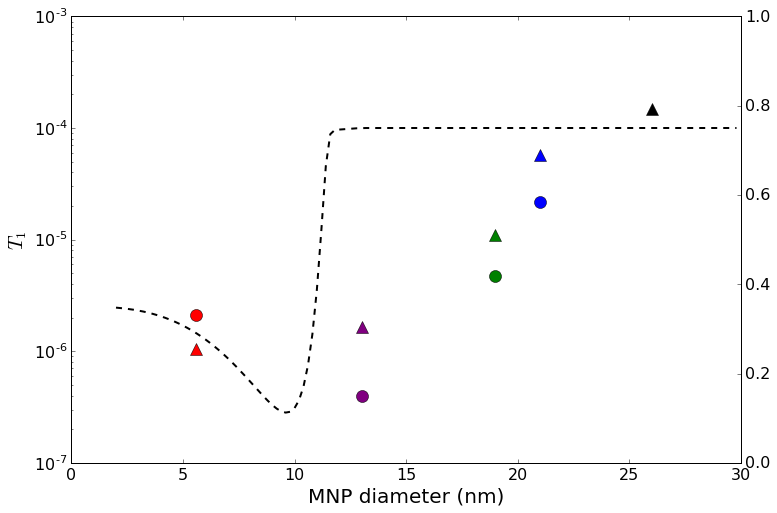

In [230]:
plt.rcParams['lines.markersize']=12
#plt.plot(R*2,T1_high,'k-',linewidth=2,label='T1')
f, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(R*2,T1_4,'k--',linewidth=2,label='T1')



ax1.plot(26,np.mean(bare_T1),'k^')


ax1.plot(5.6,np.mean(MNP2_T1),'ro')
ax1.plot(5.6,pred_time(T1_4,gaussian(R*2,5.6,1.9)),'r^')

ax1.plot(21,np.mean(MNP11_T1),'bo')
ax1.plot(21,pred_time(T1_4,gaussian(R*2,21,3.7)),'b^')


ax1.semilogy(19,np.mean(MNP5_T1),'go')
ax1.plot(19,pred_time(T1_4,gaussian(R*2,19,4.5)),'g^')


ax1.plot(13,400E-9,'o',color='purple')
ax1.plot(13,pred_time(T1_4,gaussian(R*2,13,5.5)),'^',color='purple')


#plt.plot(8,0,'go')
#plt.plot(R*2,T2,'r-o',linewidth=2,label='T2')
ax1.set_xlabel("MNP diameter (nm)",fontsize=20)
ax1.set_ylabel("$T_1$",fontsize=20)
#plt.ylabel("$T_{MNP} / T_{bare} $",fontsize=24)
ax1.set_xlim([0,30])
#ax1.set_ylim([20E-9,1E-3])
#plt.legend()


In [134]:
MNP2_T2 = np.array([256,829])*1E-9
MNP4_T2 = np.array([926,1226,961,939,729,567,2194,433,1136])*1E-9
MNP5_T2 = np.array([124,654])*1E-9
bare_T2 = 2074E-9

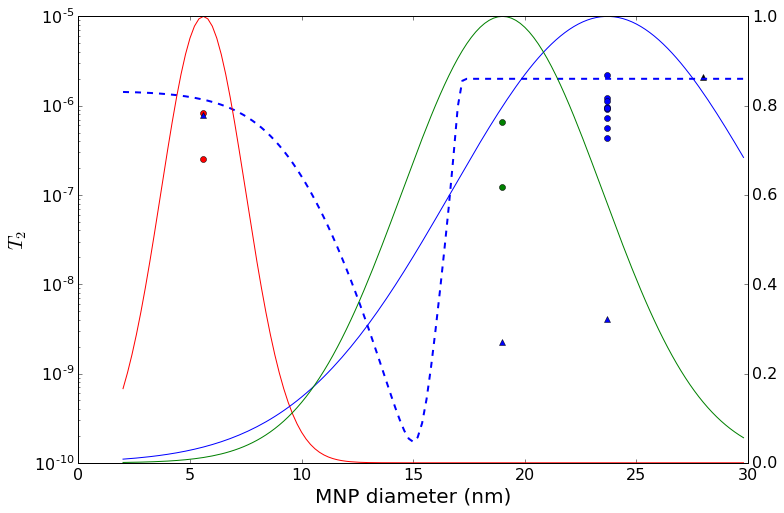

In [217]:
f, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(np.ones_like(bare_T2)*28,bare_T2,'k^')

ax1.plot(np.ones_like(MNP2_T2)*5.6,MNP2_T2,'ro')
ax2.plot(R*2,gaussian(R*2,5.6,1.9),'r-')
ax1.plot(5.6,pred_time(T2_4,gaussian(R*2,5.6,1.9)),'b^')


ax1.plot(np.ones_like(MNP4_T2)*23.7,MNP4_T2,'bo')
ax2.plot(R*2,gaussian(R*2,23.7,7),'b-')
ax1.plot(23.7,pred_time(T2_4,gaussian(R*2,23.7,7)),'b^')


ax1.semilogy(np.ones_like(MNP5_T2)*19,MNP5_T2,'go')
ax2.plot(R*2,gaussian(R*2,19,4.5),'g-')
ax1.plot(19,pred_time(T2_4,gaussian(R*2,19,4.5)),'b^')


ax1.plot(R*2,T2_4,'b--',linewidth=2,label='T2')


ax1.set_xlabel("MNP diameter (nm)",fontsize=20)
ax1.set_ylabel("$T_2$",fontsize=20)


In [ ]:
f, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(np.ones_like(bare_T2)*28,bare_T2,'k^')

ax1.plot(np.ones_like(MNP2_T2)*5.6,MNP2_T2,'ro')
ax2.plot(R*2,gaussian(R*2,5.6,1.9),'r-')

ax1.plot(np.ones_like(MNP4_T2)*23.7,MNP4_T2,'bo')
ax2.plot(R*2,gaussian(R*2,23.7,7),'b-')

ax1.semilogy(np.ones_like(MNP5_T2)*19,MNP5_T2,'go')
ax2.plot(R*2,gaussian(R*2,19,4.5),'g-')



ax1.plot(R*2,T2_0,'k--',linewidth=2,label='T2')
ax1.plot(R*2,T2_1,'r--',linewidth=2,label='T2')
ax1.plot(R*2,T2_2,'b--',linewidth=2,label='T2')
ax1.plot(R*2,T2_3,'g--',linewidth=2,label='T2')


ax1.set_xlabel("MNP diameter (nm)",fontsize=20)
ax1.set_ylabel("$T_2$",fontsize=20)


In [89]:
k =  mp.mpf(26E3)
t =  mp.mpf(10**-11.5)
T1 = mp.mpf(50*1E-6)
T2 = mp.mpf(2000*1E-9)

def b_var_T1(T1_m,r):
    b=0
    V =  mp.mpf(4/3.0*np.pi*(r*1E-9)**3)
    i = lambda f: F1(f,b,T2)*spec(f,k,V,t)
    S = mp.quad(i,[1E8,2.765E9,2.965E9,1E10])
    G_ext = 1/T1_m  - 1/T1
    B2 =  G_ext / mp.mpf(28E6**2*S)
    return np.sqrt(B2)

def b_var_T2(T2_m,r):
    tau = 1E-7
    b=0
    V =  mp.mpf(4/3.0*np.pi*(r*1E-9)**3)
    i2 = lambda f: F2(f,tau*2)*spec(f,k,V,t)
    S2 = mp.quad(i2,[1E4,1/tau-1E6,1/tau+1E6,1E8])
    G_ext2 = mp.mpf(1/mp.mpf(T2_m)  - 1/T2)
    B2_2 = mp.mpf( G_ext2 / (mp.mpf(28E6)**2*S2))
    return mp.sqrt(B2_2)

In [90]:
b_var_T1(100E-9,3)

mpf('55.11296821643299909740867478344763410151096511837453')

In [91]:
def b_var(T2_m,T1_m,t_exp,k,r):
    b=0
    k =  mp.mpf(k)
    t =  mp.mpf(10**t_exp)
    T1 = mp.mpf(100*1E-6)
    T2 = mp.mpf(200*1E-9)
    V =  mp.mpf(4/3.0*np.pi*(r*1E-9)**3)
    i = lambda f: F1(f,b,T2)*spec(f,k,V,t)
    S = mp.quad(i,[1E8,2.765E9,2.965E9,1E10])
    G_ext = mp.mpf(1/mp.mpf(T1_m)  - 1/T1)
    B2 = mp.mpf( G_ext / (mp.mpf(28E6)**2*S))
    
    tau = 1E-7
    i2 = lambda f: F2(f,tau*2)*spec(f,k,V,t)
    S2 = mp.quad(i2,[1E4,1/tau-1E6,1/tau+1E6,1E8])
    G_ext2 = mp.mpf(1/mp.mpf(T2_m)  - 1/T2)
    B2_2 = mp.mpf( G_ext2 / (mp.mpf(28E6)**2*S2))

    
    return (mp.sqrt(B2),mp.sqrt(B2_2))

In [92]:
# MNP 11
T2 = 30E-9
T1 = 9E-6
r = 10
k = np.linspace(1E4,5E4,30)
t = np.linspace(-12,-8,30)

b1 = np.zeros((30,30))
b2 = np.zeros((30,30))

for i,K in enumerate(k):
    for j,T in enumerate(t):
        
        b = b_var(T2,T1,T,K,r)
        b1[i,j] = b[0]
        b2[i,j] = b[1]
        


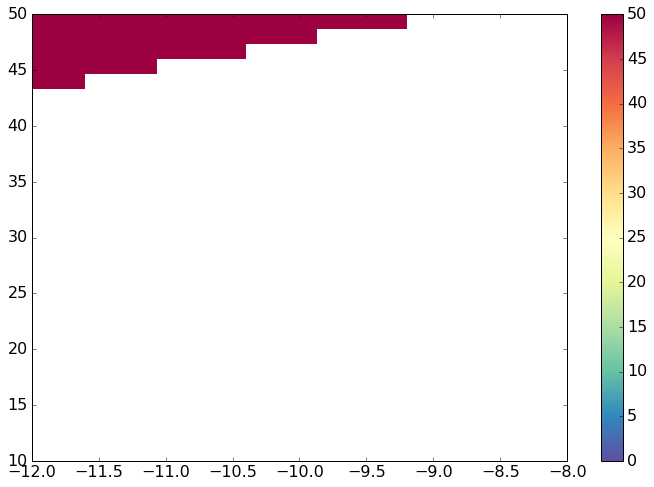

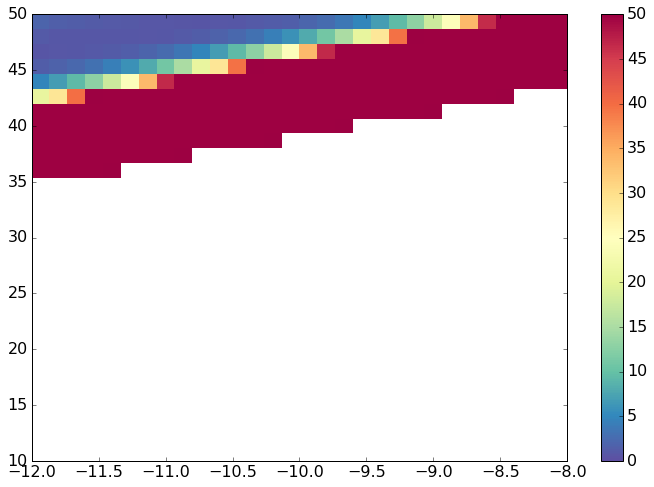

C:\Users\Ouyang Group\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: invalid value encountered in subtract


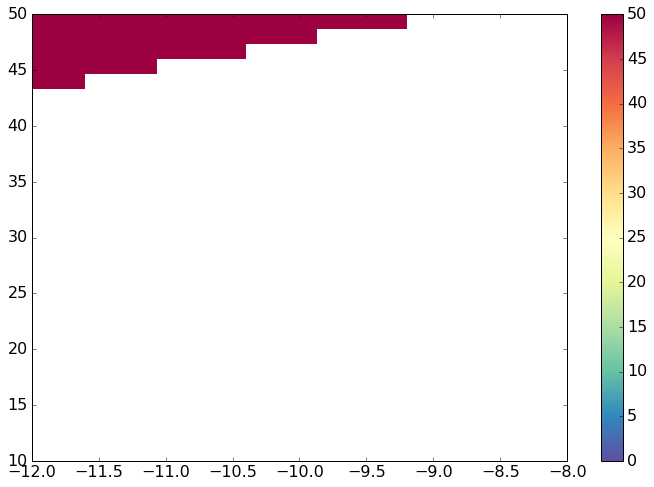

In [93]:
plt.imshow(b1,cmap=plt.get_cmap('Spectral_r'), interpolation='none', vmin=0, vmax=50,extent=[-12,-8,10,50],aspect='auto')
plt.colorbar()
plt.show()
plt.imshow(b2,cmap=plt.get_cmap('Spectral_r'), interpolation='none', vmin=0, vmax=50,extent=[-12,-8,10,50],aspect='auto')
plt.colorbar()
plt.show()
plt.imshow(np.abs(b2-b1),cmap=plt.get_cmap('Spectral_r'), interpolation='none', vmin=0, vmax=50,extent=[-12,-8,10,50],aspect='auto')
plt.colorbar()
plt.show()

In [94]:
b1

array([[  5.58482124e+001,   8.35632430e+001,   1.46605961e+002,
          3.19129874e+002,   9.30813785e+002,   4.04984358e+003,
          3.05085623e+004,   4.88636487e+005,   2.20625995e+007,
          4.13757843e+009,   5.48872654e+012,   1.07022212e+017,
          8.58934353e+022,   1.06768026e+031,   1.37737926e+042,
          2.56220818e+057,   2.52592371e+078,   1.81634013e+107,
          8.06986853e+146,   2.28947512e+201,   1.37812369e+276,
                      inf,               inf,               inf,
                      inf,               inf,               inf,
                      inf,               inf,               inf],
       [  1.83960189e+003,   1.03215518e+004,   1.10275027e+005,
          2.85465489e+006,   2.49293835e+008,   1.15718884e+011,
          5.33194507e+014,   5.75177960e+019,   4.84639953e+026,
          1.49918773e+036,   1.62743265e+049,   1.35657189e+067,
          5.88302114e+091,   4.23815605e+125,   1.36709464e+172,
          1.01245291e+23

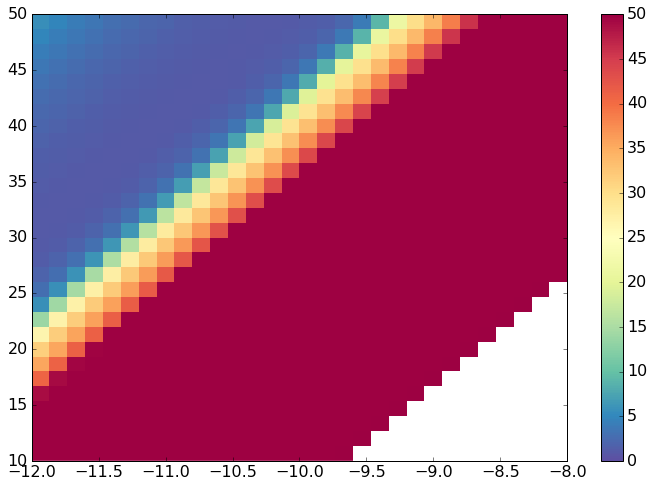

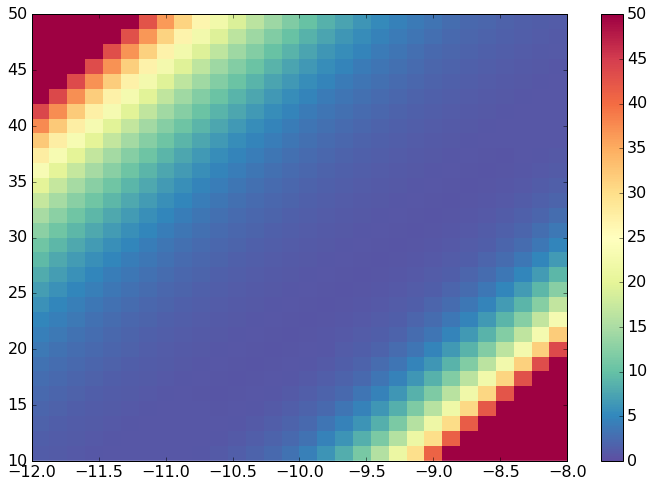

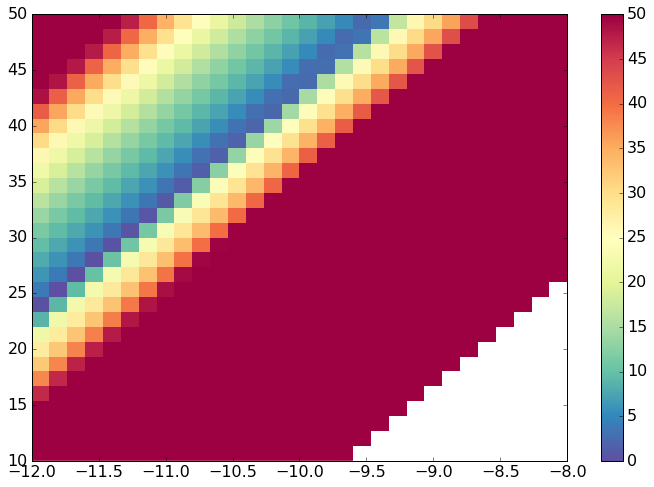

In [95]:
# MNP 5
T2 = 30E-9
T1 = 6E-6
r = 6
k = np.linspace(1E4,5E4,30)
t = np.linspace(-12,-8,30)

b1 = np.zeros((30,30))
b2 = np.zeros((30,30))

for i,K in enumerate(k):
    for j,T in enumerate(t):
        
        b = b_var(T2,T1,T,K,r)
        b1[i,j] = b[0]
        b2[i,j] = b[1]
        
plt.imshow(b1,cmap=plt.get_cmap('Spectral_r'), interpolation='none', vmin=0, vmax=50,extent=[-12,-8,10,50],aspect='auto')
plt.colorbar()
plt.show()
plt.imshow(b2,cmap=plt.get_cmap('Spectral_r'), interpolation='none', vmin=0, vmax=50,extent=[-12,-8,10,50],aspect='auto')
plt.colorbar()
plt.show()
plt.imshow(np.abs(b2-b1),cmap=plt.get_cmap('Spectral_r'), interpolation='none', vmin=0, vmax=50,extent=[-12,-8,10,50],aspect='auto')
plt.colorbar()
plt.show()

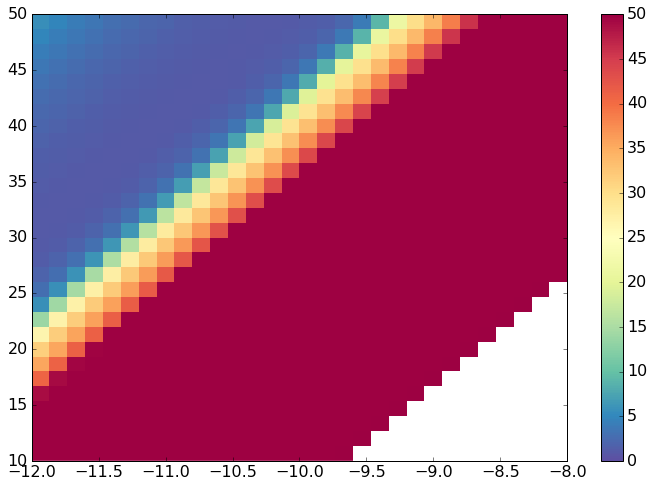

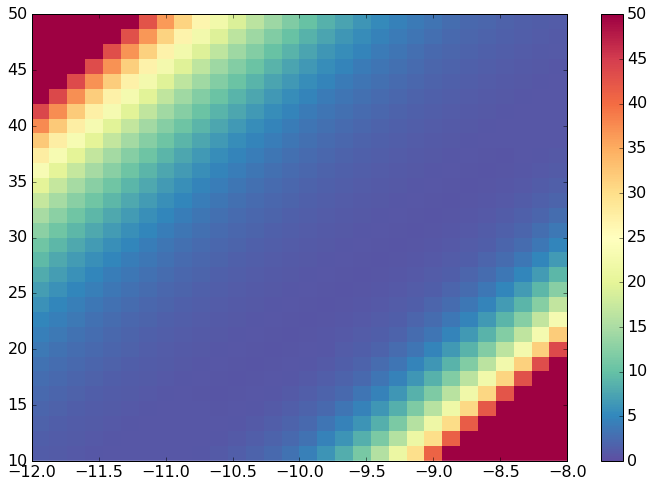

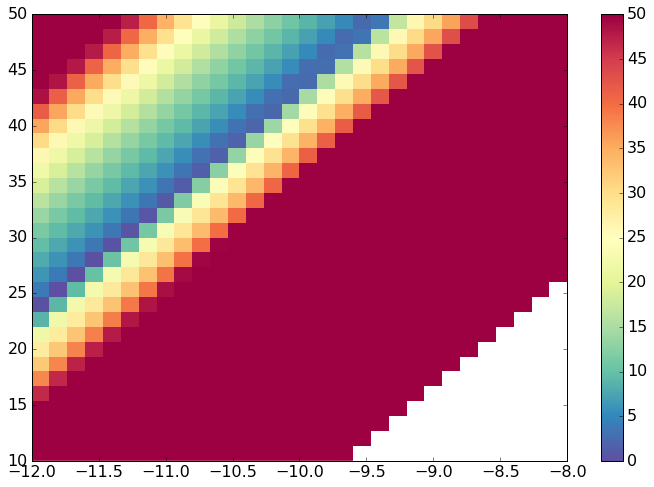

In [96]:
plt.imshow(b1,cmap=plt.get_cmap('Spectral_r'), interpolation='none', vmin=0, vmax=50,extent=[-12,-8,10,50],aspect='auto')
plt.colorbar()
plt.show()
plt.imshow(b2,cmap=plt.get_cmap('Spectral_r'), interpolation='none', vmin=0, vmax=50,extent=[-12,-8,10,50],aspect='auto')
plt.colorbar()
plt.show()
plt.imshow(np.abs(b2-b1),cmap=plt.get_cmap('Spectral_r'), interpolation='none', vmin=0, vmax=50,extent=[-12,-8,10,50],aspect='auto')
plt.colorbar()
plt.show()